Test Loss: 1.6717
Test Accuracy: 79.39%


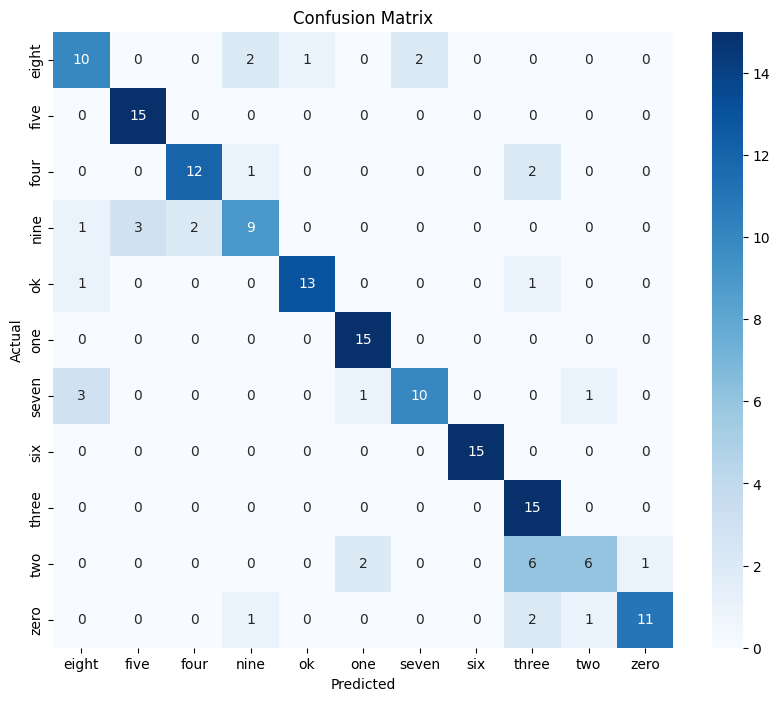

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from model import SimpleCNN
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 設定超參數
batch_size = 20

# 資料轉換
transform = transforms.Compose([
    transforms.Resize((240, 320)),
    transforms.ToTensor(),
])

# 指定測試資料集路徑
test_dir = 'dataset_scale/test'    # 指定測試資料集資料夾路徑

# 加載測試資料集
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 設定設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型
num_classes = 11
model = SimpleCNN(num_classes=num_classes).to(device)

# 加載已訓練的模型權重
model.load_state_dict(torch.load('simple_cnn_1220_epoch30.pth', weights_only=True))

# 設定損失函數
criterion = nn.CrossEntropyLoss()

# 測試函數
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    return running_loss / len(test_loader), accuracy, all_labels, all_predictions

# 執行測試
test_loss, test_accuracy, all_labels, all_predictions = test(model, test_loader, criterion, device)

# 打印結果
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')

# 計算混淆矩陣
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 繪製混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
